# <center> 1 - Summary</center>

### I - Collecting & cleaning the data

### II - Ratio's processing

### III - Performance return analysis

# <center> 1 - Instructions</center>

```- replace the "4ES6P2147EM6N59R" apikey below with your own key from https://www.alphavantage.co/support/#api-key```<br>
```- SIC Code : 1311```<br>
```- The 3 choosen assets : ```<br>
    ```- TOTAL SE (Ticker : TTE)```<br>
    ```- SHELL (Ticker : SHEL) ```<br>
    ```- ENI (Ticker : E)```<br>

### I - Collecting & cleaning the data

In [184]:
import pandas as pd
import requests
import time
from datetime import date, timedelta

pd.options.mode.chained_assignment = 'None'  # default='warn'

# API param's
api_key = '4ES6P2147EM6N59R'
tickers = ['TTE','SHEL','E']

In [185]:


# set new dataframes
appended_data_inc = []
appended_data_bal = []

for t in tickers:
    print('$$ Start processing : ' + t)
    # Defining API Url's 
    url_inc = 'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol=' + t + '&apikey=' + api_key
    url_bal = 'https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol=' + t + '&apikey=' + api_key

    # Requests the API
    r_inc = requests.get(url_inc)
    r_bal = requests.get(url_bal)

    # Transforming requested data into json format
    data_inc = r_inc.json()
    data_bal = r_bal.json()

    # Printing json structure
    #print(data_inc)
    #print(data_bal)

    # Json data filtering
    json_data_inc = data_inc['annualReports']
    json_data_bal = data_bal['annualReports']

    #Transform json format to dataframe
    df_data_inc = pd.DataFrame.from_dict(json_data_inc, orient='columns')
    df_data_bal = pd.DataFrame.from_dict(json_data_bal, orient='columns')

    # ID column to identify the compagny
    df_data_inc['ticker'] = t
    df_data_bal['ticker'] = t
    
    # Append data (add rows from new dataframe)
    appended_data_inc.append(df_data_inc)
    appended_data_bal.append(df_data_bal)
    
    # timer : for not reaching the API limits 
    time.sleep(30)
    print('$$ End processing : ' + t)
    
# concat all dataframes into one   
df_data_inc = pd.concat(appended_data_inc, ignore_index=True)
df_data_bal = pd.concat(appended_data_bal, ignore_index=True)

# print results
print(df_data_inc.head(3))
print(df_data_bal.head(3))
#df_data_inc.to_csv('working_data.csv')

$$ Start processing : TTE
$$ End processing : TTE
$$ Start processing : SHEL
$$ End processing : SHEL
$$ Start processing : E
$$ End processing : E
  fiscalDateEnding reportedCurrency  grossProfit  totalRevenue costOfRevenue  \
0       2022-12-31              USD  81641000000  263310000000  181669000000   
1       2021-12-31              EUR  52456000000  184634000000  132178000000   
2       2020-12-31              EUR  19954000000  119704000000   99750000000   

  costofGoodsAndServicesSold operatingIncome sellingGeneralAndAdministrative  \
0               181669000000     45672000000                            None   
1               132178000000     27857000000                            None   
2                99750000000     -4871000000                            None   

  researchAndDevelopment operatingExpenses  ... depreciationAndAmortization  \
0                   None       31088000000  ...                 13680000000   
1                   None       27634000000  ...     

In [2]:
#########################
# Collecting Forex data :
#########################
# init params
date_list = ['2022-12-30','2021-12-31','2020-12-31','2019-12-31','2018-12-31']
value_list = []

# Forex EUR/USD api
url_eurusd = 'https://www.alphavantage.co/query?function=FX_DAILY&from_symbol=EUR&to_symbol=USD&outputsize=full&apikey=' + api_key

# Requests the API
r_eurusd = requests.get(url_eurusd)

# Transforming requested data into json format
data_eurusd = r_eurusd.json()

# Json data filtering
for dt in date_list:
    json_data_eurusd = data_eurusd['Time Series FX (Daily)'][dt]['4. close']
    eurusd_value = float(json_data_eurusd)
    value_list.append(eurusd_value)

# Create dataframe result
date_list[0] = '2022-12-31'                                                         #replace 2022-12-30 by 2022-12-31 (2022-12-31 doesn't exists in the FX data)
df_eurusd = pd.DataFrame({'date': date_list, 'eurusd_close': value_list})   
print(df_eurusd)


         date  eurusd_close
0  2022-12-31       1.07025
1  2021-12-31       1.13659
2  2020-12-31       1.22138
3  2019-12-31       1.12129
4  2018-12-31       1.14660


In [3]:
#########################
#### Cleaning data
#########################

# Sample data :
df_income = df_data_inc[['ticker','fiscalDateEnding','reportedCurrency','grossProfit','netIncome','totalRevenue','operatingIncome']]
df_balance = df_data_bal[['ticker','fiscalDateEnding','reportedCurrency','totalAssets','totalCurrentAssets','cashAndCashEquivalentsAtCarryingValue','totalCurrentLiabilities','cashAndShortTermInvestments','totalShareholderEquity']]


# str to float convertion
df_income = df_income.astype({'grossProfit':'float',
                  'netIncome':'float',
                  'totalRevenue':'float',
                  'operatingIncome':'float'})
df_balance = df_balance.astype({'totalShareholderEquity':'float',
                                'totalAssets':'float',
                                'totalCurrentAssets':'float',
                                'cashAndCashEquivalentsAtCarryingValue':'float',
                                'totalCurrentLiabilities':'float',
                                'cashAndShortTermInvestments':'float'})

# currency convertion USD -> EUR (EUR/USD = 1.0666 as of 2022-12-31)
df_income = df_income.merge(df_eurusd, left_on=['fiscalDateEnding'], right_on=['date'], )
df_balance = df_balance.merge(df_eurusd, left_on=['fiscalDateEnding'], right_on=['date'])

# COnvertion
df_income.loc[df_income['reportedCurrency'] == 'USD', 'grossProfit'] = df_income['grossProfit'] / df_income['eurusd_close']
df_income.loc[df_income['reportedCurrency'] == 'USD', 'netIncome'] = df_income['netIncome'] / df_income['eurusd_close']
df_income.loc[df_income['reportedCurrency'] == 'USD', 'totalRevenue'] = df_income['totalRevenue'] / df_income['eurusd_close']
df_income.loc[df_income['reportedCurrency'] == 'USD', 'operatingIncome'] = df_income['operatingIncome'] / df_income['eurusd_close']

df_balance.loc[df_balance['reportedCurrency'] == 'USD', 'totalShareholderEquity'] = df_balance['totalShareholderEquity'] / df_balance['eurusd_close']
df_balance.loc[df_balance['reportedCurrency'] == 'USD', 'totalAssets'] = df_balance['totalAssets'] / df_balance['eurusd_close']
df_balance.loc[df_balance['reportedCurrency'] == 'USD', 'totalCurrentAssets'] = df_balance['totalCurrentAssets'] / df_balance['eurusd_close']
df_balance.loc[df_balance['reportedCurrency'] == 'USD', 'cashAndCashEquivalentsAtCarryingValue'] = df_balance['cashAndCashEquivalentsAtCarryingValue'] / df_balance['eurusd_close']
df_balance.loc[df_balance['reportedCurrency'] == 'USD', 'totalCurrentLiabilities'] = df_balance['totalCurrentLiabilities'] / df_balance['eurusd_close']
df_balance.loc[df_balance['reportedCurrency'] == 'USD', 'cashAndShortTermInvestments'] = df_balance['cashAndShortTermInvestments'] / df_balance['eurusd_close']

print(df_income.sort_values(['ticker', 'fiscalDateEnding']))
print(df_balance.sort_values(['ticker', 'fiscalDateEnding']))


   ticker fiscalDateEnding reportedCurrency   grossProfit     netIncome  \
14      E       2018-12-31              USD  1.152276e+10  3.598465e+09   
11      E       2019-12-31              USD  9.721838e+09  1.319908e+08   
8       E       2020-12-31              USD  2.564312e+09 -7.064141e+09   
5       E       2021-12-31              EUR  1.396800e+10  5.821000e+09   
2       E       2022-12-31              EUR  2.277600e+10  1.388700e+10   
13   SHEL       2018-12-31              USD  3.913745e+10  2.036630e+10   
10   SHEL       2019-12-31              USD  3.277921e+10  1.412926e+10   
7    SHEL       2020-12-31              USD -1.063960e+10 -1.763006e+10   
4    SHEL       2021-12-31              USD  3.153996e+10  1.768536e+10   
1    SHEL       2022-12-31              USD  7.360804e+10  3.953189e+10   
12    TTE       2018-12-31              EUR  4.429800e+10  1.144600e+10   
9     TTE       2019-12-31              EUR  4.429700e+10  1.126700e+10   
6     TTE       2020-12-3

### II - Ratio's processing

In [4]:
#########################
#### Profitability ratios
#########################

###########################
#### Gross margin
df_result = df_income[['ticker','fiscalDateEnding','grossProfit','totalRevenue','operatingIncome','netIncome']]

##########################
#### Operating margin
# Operating Margin (OM) = Operating Earnings (column : operatingIncome) / Revenue (column : totalRevenue)
df_result['operatingMargin'] = df_result['operatingIncome'] / df_result['totalRevenue'] * 100


###########################
#### Return on Equity (ROE)
# ROE = Net Income (column :  netIncome (df_inc_data)) / Average Shareholders’ Equity (column :  totalShareholderEquity (df_bal_data))
df_result = df_result.merge(df_balance, left_on=['ticker','fiscalDateEnding'], right_on=['ticker','fiscalDateEnding'])
df_result['returnOnEquity'] = df_result['netIncome'] / df_result['totalShareholderEquity'] * 100

print(df_result[['ticker','fiscalDateEnding','grossProfit','operatingMargin','returnOnEquity']])

   ticker fiscalDateEnding   grossProfit  operatingMargin  returnOnEquity
0     TTE       2022-12-31  7.628218e+10        17.345334       18.372060
1    SHEL       2022-12-31  7.360804e+10        17.663396       22.212714
2       E       2022-12-31  2.277600e+10        17.478467       25.360215
3     TTE       2021-12-31  5.245600e+10        15.087687       14.348106
4    SHEL       2021-12-31  3.153996e+10        10.493530       11.689006
5       E       2021-12-31  1.396800e+10        16.117278       13.099444
6     TTE       2020-12-31  1.995400e+10        -4.069204       -7.074116
7    SHEL       2020-12-31 -1.063960e+10       -12.671220      -13.864529
8       E       2020-12-31  2.564312e+09         5.140155      -23.060270
9     TTE       2019-12-31  4.429700e+10        11.155808        9.648221
10   SHEL       2019-12-31  3.277921e+10         8.749786        8.495999
11      E       2019-12-31  9.721838e+09        17.674332        0.309371
12    TTE       2018-12-31  4.429800e+

In [5]:
#########################
## Liquidity ratios
#########################

###########################
#### Quick ratio (QR) 
#   QR =  C+MS+AR / CL
#   C = cash & cash equivalents (column : cashAndCashEquivalentsAtCarryingValue)
#   MS = marketable securities (column : cashAndShortTermInvestments)
#   AR = accounts receivable (column : currentNetReceivables)
#   CL = current liabilities (column : totalCurrentLiabilities)
#df_QR = df_balance[['fiscalDateEnding','cashAndCashEquivalentsAtCarryingValue','cashAndShortTermInvestments','totalCurrentLiabilities']]
df_result['quickRatio'] = ((df_result['cashAndCashEquivalentsAtCarryingValue'] + df_result['cashAndShortTermInvestments']) / df_result['totalCurrentLiabilities']) * 100


###########################
#### Cash ratio (CR) 
#   CR = (Cash + Marketable Securities) (column : cashAndCashEquivalentsAtCarryingValue) / Current Liabilities (column : totalCurrentLiabilities)
df_result['cashRatio'] = (df_result['cashAndCashEquivalentsAtCarryingValue'] / df_result['totalCurrentLiabilities']) * 100

print(df_result[['ticker','fiscalDateEnding','quickRatio','cashRatio']])

   ticker fiscalDateEnding  quickRatio  cashRatio
0     TTE       2022-12-31   60.168704  30.084352
1    SHEL       2022-12-31   66.352321  33.176160
2       E       2022-12-31   41.596690  20.798345
3     TTE       2021-12-31   44.882337  22.441168
4    SHEL       2021-12-31   77.388092  38.694046
5       E       2021-12-31   38.145855  19.072927
6     TTE       2020-12-31   96.691199  48.345600
7    SHEL       2020-12-31   86.085193  43.042596
8       E       2020-12-31   79.464776  39.732388
9     TTE       2019-12-31   77.877114  38.938557
10   SHEL       2019-12-31   45.347567  22.673783
11      E       2019-12-31   40.441251  20.220625
12    TTE       2018-12-31   89.684096  44.842048
13   SHEL       2018-12-31   68.731446  34.365723
14      E       2018-12-31   76.358255  38.179128


Text(0, 0.5, 'cashRatio - %')

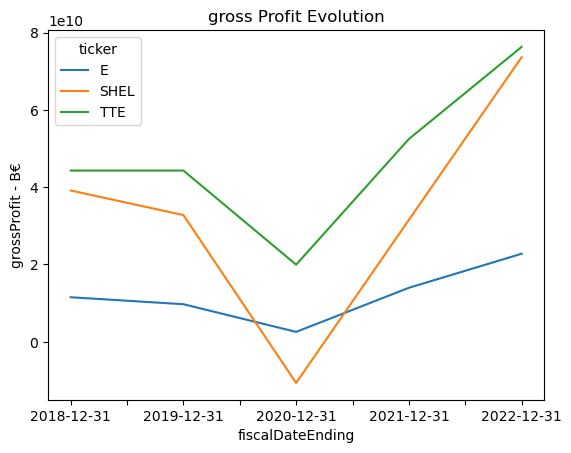

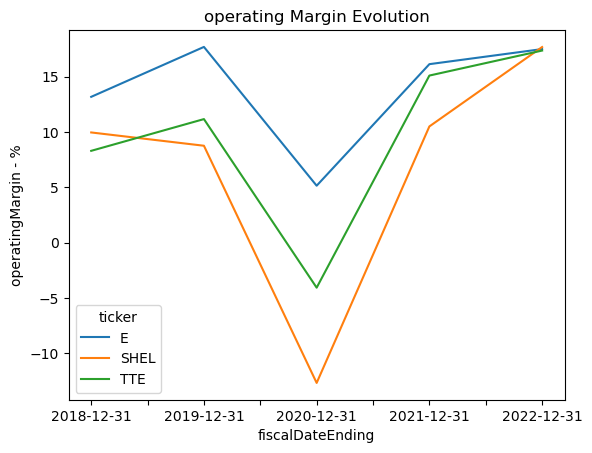

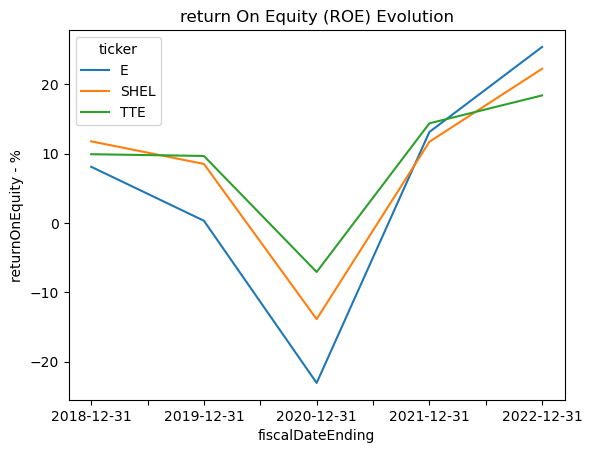

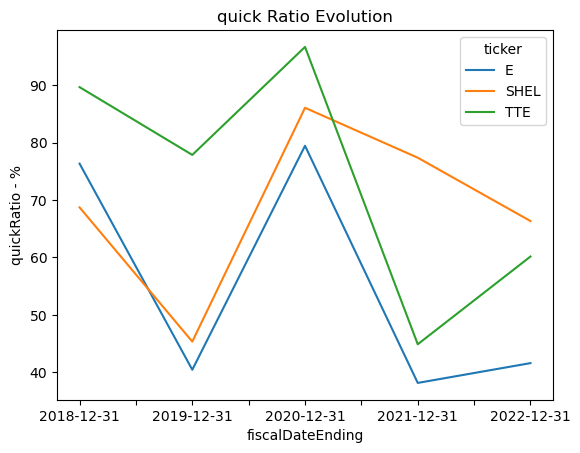

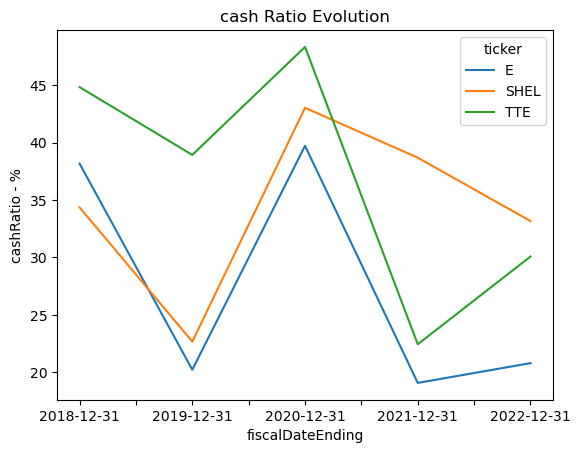

In [6]:
#########################
## Plot results
#########################

#### Gross margin
ax = df_result.pivot_table(values="grossProfit",index="fiscalDateEnding",columns="ticker").plot()
ax.set_title('gross Profit Evolution')
ax.set_ylabel('grossProfit - B€')

#### Operating margin
ax = df_result.pivot_table(values="operatingMargin",index="fiscalDateEnding",columns="ticker").plot()
ax.set_title('operating Margin Evolution')
ax.set_ylabel('operatingMargin - %')

#### Return on Equity (ROE)
ax = df_result.pivot_table(values="returnOnEquity",index="fiscalDateEnding",columns="ticker").plot()
ax.set_title('return On Equity (ROE) Evolution')
ax.set_ylabel('returnOnEquity - %')

#### Quick ratio (QR)
ax = df_result.pivot_table(values="quickRatio",index="fiscalDateEnding",columns="ticker").plot()
ax.set_title('quick Ratio Evolution')
ax.set_ylabel('quickRatio - %')

#### Cash ratio (CR) 
ax = df_result.pivot_table(values="cashRatio",index="fiscalDateEnding",columns="ticker").plot()
ax.set_title('cash Ratio Evolution')
ax.set_ylabel('cashRatio - %')


### III - Performance return analysis

In [205]:
# set new dataframes
sdate = date(2017,12,31)
edate = date.today()
dt_list = list(pd.date_range(sdate,edate-timedelta(days=1),freq='d').strftime("%Y-%m-%d"))

print(dt_list)

appended_data_prices = []
date_list = []
value_list = []
ticker_list =[]

for t in tickers:
    print('$$ Start processing : ' + t)
    # Defining API Url's 
    url_prices = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=' + t + '&outputsize=full&apikey=' + api_key

    # Requests the API
    r_prices = requests.get(url_prices)

    # Transforming requested data into json format
    data_prices = r_prices.json()

    # Printing json structure
    #print(data_prices)

    # Json data filtering
    for dt in dt_list:
        
        try:
            json_data_prices = data_prices['Time Series (Daily)'][dt]['4. close']
            price_value = float(json_data_prices)
            date_list.append(dt)
            value_list.append(price_value)
            ticker_list.append(t)
        except KeyError:
            pass
    
    print('$$ End processing : ' + t)
    
# Create dataframe result
df_prices = pd.DataFrame({'ticker': ticker_list, 'date': date_list, 'price_value': value_list})   

print(df_prices)

['2017-12-31', '2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12', '2018-01-13', '2018-01-14', '2018-01-15', '2018-01-16', '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20', '2018-01-21', '2018-01-22', '2018-01-23', '2018-01-24', '2018-01-25', '2018-01-26', '2018-01-27', '2018-01-28', '2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01', '2018-02-02', '2018-02-03', '2018-02-04', '2018-02-05', '2018-02-06', '2018-02-07', '2018-02-08', '2018-02-09', '2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13', '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-17', '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21', '2018-02-22', '2018-02-23', '2018-02-24', '2018-02-25', '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01', '2018-03-02', '2018-03-03', '2018-03-04', '2018-03-05', '2018-03-06', '2018-03-07', '2018-03-08', '2018-03-09', '2018-03-10', '2018-03-11', '2018

Text(0, 0.5, 'StockPrice - ')

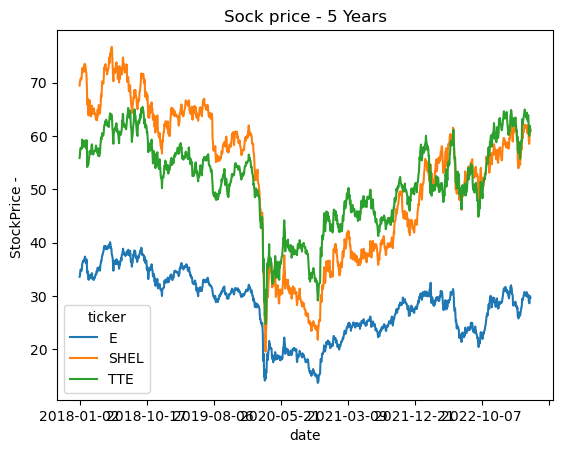

In [206]:
# Check trading currency : 
# SHEL : USD
# TTE : USD
# E : USD
# ->> OK

# plot stocks price series :
ax = df_prices.pivot_table(values="price_value",index="date",columns="ticker").plot()
ax.set_title('Sock price - 5 Years')
ax.set_ylabel('StockPrice - ')


In [208]:
# Create new index row based on tickers and dates
df_prices = df_prices.set_index(['ticker','date'])
print(df_prices)

                   price_value
ticker date                   
TTE    2018-01-02        55.87
       2018-01-03        56.44
       2018-01-04        57.41
       2018-01-05        57.77
       2018-01-08        57.78
...                        ...
E      2023-05-03        28.66
       2023-05-04        28.65
       2023-05-05        30.01
       2023-05-08        29.87
       2023-05-09        29.70

[4041 rows x 1 columns]


In [204]:
###############################
# Rebase stock prices from $100
###############################
# Create new index row based on tickers and dates
df_prices = df_prices.set_index(['ticker','date'])

# create dataframe of first price grouped by each ticker
firsts = (df_prices.groupby(level=['ticker']).transform('first'))

# formula (rebased price = current value / initial value * 100)
df_prices_rebased = df_prices / firsts * 100

# plot rebased prices from $100
ax = df_prices_rebased.pivot_table(values="price_value",index="date",columns="ticker").plot()
ax.set_title('Sock price rebased ($) - 5 Years')
ax.set_ylabel('StockPrice ($)')

                   price_value
ticker date                   
TTE    2018-01-02        55.87
       2018-01-03        56.44
       2018-01-04        57.41
       2018-01-05        57.77
       2018-01-08        57.78
...                        ...
E      2023-05-03        28.66
       2023-05-04        28.65
       2023-05-05        30.01
       2023-05-08        29.87
       2023-05-09        29.70

[4041 rows x 1 columns]
                   price_value
ticker date                   
TTE    2018-01-02   100.000000
       2018-01-03   101.020226
       2018-01-04   102.756399
       2018-01-05   103.400752
       2018-01-08   103.418650
...                        ...
E      2023-05-03    85.272240
       2023-05-04    85.242487
       2023-05-05    89.288902
       2023-05-08    88.872359
       2023-05-09    88.366558

[4041 rows x 1 columns]


In [209]:
##############################
# Perform stock return formula
##############################

# create dataframe of first value grouped by ticker :
firsts = (df_prices.groupby(level=['ticker']).transform('first'))
lasts = (df_prices.groupby(level=['ticker']).transform('last'))

# re create the index, drop date column and set the ticker as index of the dataframe :
firsts = firsts.reset_index()
firsts = firsts.drop('date', axis=1).drop_duplicates()
firsts = firsts.set_index(['ticker'])

lasts = lasts.reset_index()
lasts = lasts.drop('date', axis=1).drop_duplicates()
lasts = lasts.set_index(['ticker'])

# calculate stocks return :
df_stocks_return = (( lasts / firsts) - 1 ) * 100

print(df_stocks_return)


        price_value
ticker             
TTE        9.343118
SHEL     -12.384793
E        -11.633442


Text(0, 0.5, 'Returns (%)')

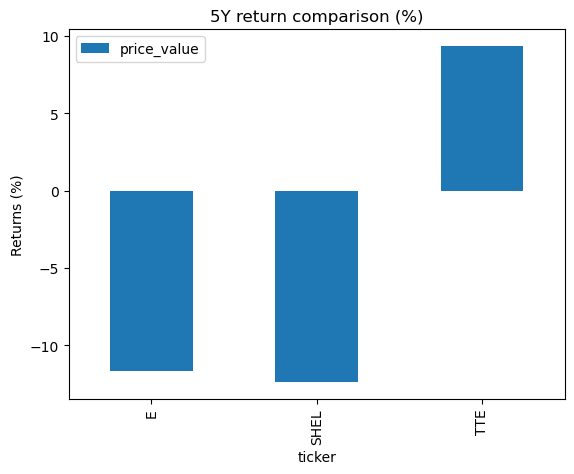

In [180]:
# plot bar chart of 5 year stocks return :
ax = df_stocks_return.plot.bar()
ax.set_title('5Y return comparison (%)')
ax.set_ylabel('Returns (%)')